# CT Readers: DICOM & RAW — Usage Guide

This notebook documents the **common classes to load CT volumes** into the ChestXSim simulation pipeline.
It shows how to:

- Load **DICOM** studies (typical starting point when you receive a CT).
- Load **RAW (.img + info.txt)** volumes with metadata-driven decoding (dtype, endianness, order ). This is the standard format used by the pipeline to save intermediate simulation steps, allowing you to reload and continue from any stage.
- Combine **multi‑tissue** RAW volumes (e.g., bone/soft) using `load_multi_tissue`.
- Understand how readers return data via the **`volumeData`** structure for direct use in the pipeline.
- Call the low-level **`read_volume`** functions when you only need the raw arrays for other tasks. 

## Overview

ChestXSim exposes an abstract base class `CTReader` and two concrete implementations:

- `DicomReader` — loads all slices in a DICOM folder, sorts by **InstanceNumber** (if present)
- `RawReader` — loads a single **.img** file plus a paired **info.txt** that declares how to decode the binary (shape, dtype, byte order, memory order, etc.).

Both readers return a `volumeData` object:  
- `volumeData.volume` → an xp array (NumPy or CuPy backend) representing the 3D volume in **[x, y, z]** 
- `volumeData.metadata` → a `MetadataContainer` (dimensions, voxel size, custom init fields, etc.)

> **Tip:** If you only want the array (and not the full `volumeData`) you can call each reader’s `read_volume` method directly.

### Folder Layouts

**DICOM**
```
/path/to/dicom_case/
├─ 0001.dcm
├─ 0002.dcm
└─ ...
```

**RAW (single‑tissue case)**
```
/path/to/raw_case/
├─ info.txt          # required
├─ log.txt           # optional
└─ raw_case.img      # binary payload (basename must match folder name)
```

**RAW (multi‑tissue case)**
```
/path/to/base_or_parent/
├─ bone/
│  └─ CASE_ID/
│     ├─ info.txt
│     └─ CASE_ID.img
├─ soft/
   └─ CASE_ID/
      ├─ info.txt
      └─ CASE_ID.img
```

### `info.txt` Specification (RAW)

**Required:**
- `dim: (W, H, D)`
- `voxel_size: (sx, sy, sz)`

**Optional (defaults):**
- `dtype:` `"float32" | "uint16" | "<f4" | ">i16" | ...`  (default `"<f4"`)
- `endianness:` `"<" | ">" | "="` *(ignored if `dtype` encodes it)*
- `order:` `"F" | "C"`  (default `"F"`)
- `scale:` `float`  (default `1.0`)
- `intercept:` `float`  (default `0.0`)
- `id:` `str`



## Quickstart: DICOM

Load a case and receive a `volumeData` ready for the simulation pipeline.

Volume shape: (512, 512, 276)
Voxel size: (0.84, 0.84, 1.25)


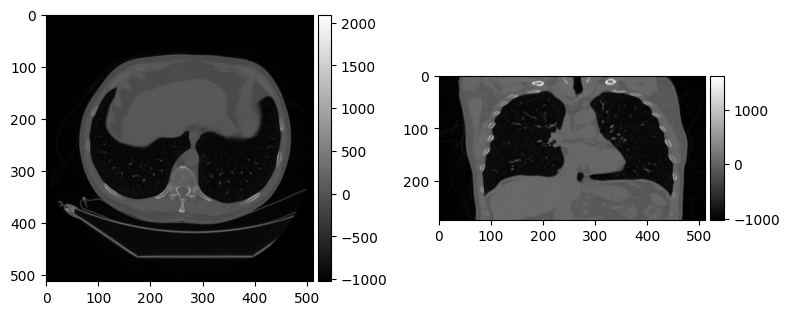

In [3]:
from chestxsim.io.readers import DicomReader 
from chestxsim.utility.visualization import plot
from chestxsim.io.paths import INPUTS_DIR

dicom_files = INPUTS_DIR / "NODULO\S18\S20" # Path containing Dicom files 
reader = DicomReader(convert_to_HU=True, clip_values=(-1024.0, 3000.0))
ct_data = reader.read(dicom_files)

print("Volume shape:", ct_data.volume.shape)       # [x, y, z]
print("Voxel size:", ct_data.metadata.voxel_size)
plot(ct_data.volume.get()[:,:,200].T,ct_data.volume.get()[:,225,:].T)


## Quickstart: RAW (Single‑Tissue)

The `.img` file is decoded using parameters from `info.txt`.

Volume shape: (512, 348, 436, 1)
Voxel size: (0.84, 0.84, 1.25)
dtype param: int16
Volume unints: mu


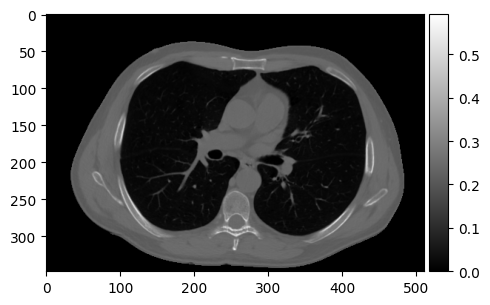

In [4]:
from chestxsim.io.readers import RawReader  
from chestxsim.io.paths import RESULTS_DIR

raw_case_folder = RESULTS_DIR / "CT_converted" /"mus"/ "NODULO_S18_S20"
raw_reader = RawReader(convert_to_HU=False)
ct_data = raw_reader.read(raw_case_folder)
md = ct_data.metadata

print("Volume shape:", ct_data.volume.shape)       # (W, H , D, T)
print("Voxel size:", md.voxel_size)
print("dtype param:", md.dtype)
print("Volume unints:", md.find("units"))

plot(ct_data.volume.get()[:,:,200,0].T)

If a `log.txt` file is present, it is automatically parsed, allowing you to view all recorded preprocessing steps that were applied to the original CT volume using `ct_data.metadata.show_steps()`

In [ ]:
ct_data.metadata.show_steps()

> **Note:** The `tissue_type` field is empty because no tissue segmentation has been performed. Aside from virtual patient repositioning, only the unit conversion from `**Hounsfield Units (HU)** to  **linear attenuation coefficients (μ)** has been applied to the original volume.

## RAW (Multi‑Tissue)

After processing, each tissue may be stored into a seperate RAW volume. 
Use `load_multi_tissue(base_path, case_id, combine_method)` to automatically load and combine these tissues for a given case:
- `combine_method="sum"` → merges all tissue channels into a single 3D volume → shape `(W, H, D)`
- `combine_method="stack"` → stacks tissues along a new channel axis → shape `(W, H, D, T)`, where **T** is the number of tissues

In [5]:
base_path = RESULTS_DIR / "CT_converted" /"density"/ "NODULO_S18_S20"
case_id = "NODULO_S18_S20"
raw_reader = RawReader()

# Sum the tissues (single channel)
ct_sum = raw_reader.load_multi_tissue(base_path, case_id, combine_method="sum")
print("Summed shape:", ct_sum.volume.shape)         # (W, H , D, T)

# Stack the tissues (multi-channel)
ct_stack = raw_reader.load_multi_tissue(base_path, case_id, combine_method="stack")
print("Stacked shape:", ct_stack.volume.shape)      # (W, H , D, T)


[RawReader] Found tissue 'bone' at D:\bhermosi\chestxsim-project\results\CT_converted\density\bone\NODULO_S18_S20
[RawReader] Found tissue 'soft' at D:\bhermosi\chestxsim-project\results\CT_converted\density\soft_tissue\NODULO_S18_S20
Summed shape: (512, 348, 436)
[RawReader] Found tissue 'bone' at D:\bhermosi\chestxsim-project\results\CT_converted\density\bone\NODULO_S18_S20
[RawReader] Found tissue 'soft' at D:\bhermosi\chestxsim-project\results\CT_converted\density\soft_tissue\NODULO_S18_S20
Stacked shape: (512, 348, 436, 2)



> The resulting `volumeData.metadata.tissue_types` lists the tissue order corresponding to the stacked channels.

Available tissues: ['bone', 'soft']


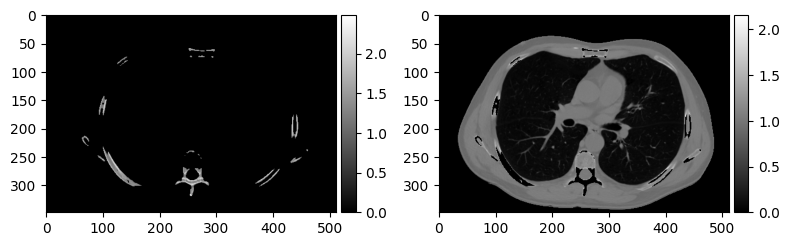

In [6]:
print("Available tissues:", ct_stack.metadata.tissue_types)
plot(
    ct_stack.volume.get()[:, :, 200, 0].T,   # Tissue 0
    ct_stack.volume.get()[:, :, 200, 1].T    # Tissue 1
)

> **Note:** See the changes in the final preprocessing step `UnitConverter`, the volume is now expressed in **density units (g/cm³)** per each tissue type rather than **attenuation coefficients (μ)** for the whole volume.
This conversion is required for accurately modeling **beam-hardening effects** during X-ray simulation:

In [7]:
ct_stack.metadata.show_steps()


--- Simulation Steps ---
clip_values: [-1024, 3000]
BedRemover: {'bed_removed': True, 'method': 'dl'}
AirCropper: {'axis': 1, 'crop_indices': [62, 410]}
VolumeExtender: {'extension_mm': [100, 100]}
TissueSegmenter: {'tissue_segmented': True, 'method': 'analytical', 'tissue_types': ['bone', 'soft']}
UnitConverter: {'units': 'density', 'e_eff': 47.3, 'mac_eff_water': 0.23617, 'tissue_type': ['bone', 'soft'], 'mu_factor': [2.0, 1.0]}


## Low‑Level Access (`read_volume`)

In some cases, you may only need to load the **raw voxel array** without any of the higher-level structures or metadata.
These static methods return only the volume itself — **no `MetadataContainer` or `volumeData`object is created**.

- `DicomReader.read_volume(dicom_folder, shape, dtype)`
- `RawReader.read_volume(file_path, shape, dtype, endianness, order)`

In [ ]:
# Example: low-level RAW read

file_path   = r"D:\bhermosi\chestxsim-project\examples\volumes\NODULO_S18_S20.img"
shape       = (512, 512, 276)      # (W, H, D)
voxel_size  = (0.84, 0.84, 1.25)   # (sx, sy, sz)
dtype       = "<f4"                # or "uint16", ">i16", ...
endianness  = None                 # applied only if dtype lacks byte order
order       = "F"                  # "F" or "C"
scale       = 1.0
intercept   = 0.0

# raw_vol = RawReader.read_volume(file_path, shape, dtype, endianness, order)


# print("Volume shape:", raw_vol.shape) 
# plot(raw_vol.get()[:, :, 200].T)

You can later wrap the returned array manually into a `volumeData` if needed:

In [ ]:
# from chestxsim.core.data_containers import volumeData, MetadataContainer
# vd = volumeData(volume=raw_vol)
# print("Volume shape:", vd.volume.shape)

At this level, no information about preprocessing or simulation steps is available. If you need it, **manually create a `MetadataContainer`**, add any relevant fields (e.g., voxel size) and record step outputs, then assign it to your `volumeData`.

In [ ]:
# # Add metadata you know (e.g., from info.txt or your notes)
# md = MetadataContainer(
#     dim=shape,                     # (W, H, D)
#     voxel_size=voxel_size,         # (sx, sy, sz) in mm
#     id="NODULO_S18_S20",
# )

# # Optionally record processing steps/parameters for traceability
# md.step_outputs["UnitConverter"] = {"units": "mu"}

# # Attach metadata to the volume
# vd.metadata = md

# print("Voxel size:", vd.metadata.voxel_size)
# print("Units:", vd.metadata.find("units"))  


## Notes & Tips

- **Axis conventions**: The readers ensure the processing pipeline sees volumes consistently as **[x, y, z]** downstream.
- **CuPy vs NumPy**: The xp backend switches to CuPy if a GPU is available; otherwise NumPy is used. Do not forget to use the `get()`method to retrieve the array for inspection and visualization if the array resides in GPU.
- **Convert to HU**: Set `convert_to_HU=True` in the base `CTReader` to apply `slope` and `intercept` automatically (if present).
- **Clipping**: Use `clip_values=(minHU, maxHU)` to constrain voxel values after loading.
Recommended default range: **(-1000, 3000)** HU — suitable for most chest CTs and compatible with models trained in that range.
